In [1]:
import tensorflow as tf
import time
import json
import pickle
import re
import html
import sys
import gc
import numpy as np
from pandas import DataFrame
from scipy.stats import spearmanr, pearsonr
import os
import gensim
import keras

from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, scale
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

from corpora_utils import CorporaHelper,CorporaDomains, CorporaProperties
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Input, Conv1D
from keras.layers.wrappers import Bidirectional
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD, Adagrad
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM, GRU
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.backend.tensorflow_backend import set_session
from keras.preprocessing.sequence import pad_sequences

from nltk import word_tokenize
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize.casual import TweetTokenizer
from keras.callbacks import TensorBoard
from IPython.display import display, HTML
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv1D
from keras import layers
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, StratifiedKFold
from corpora_utils import CorporaHelper,CorporaDomains, CorporaProperties
import numpy as np
import os
import pickle

Using TensorFlow backend.


In [2]:
"""
#Activate GPU
#WARNING GPU TAKES 5 TIMES LONGER THAN CPU! With Consul Project 1
#Check for GPU
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
# GPU CONFIG
config = tf.compat.v1.ConfigProto(
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
"""

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [ ]:
"""
Deep learning with multigenre corpus and 4 emotions
"""
# K-Fold variables
num_folds = 10 # 10
fold_runs = 1 # 3
fold_no = 1

MULTIGENRE = True
TWITTER = False

In [4]:
# set wich corpora to use Multigenre or twitter
use_mg_train_corpora = MULTIGENRE

In [5]:
# train
epochs = 10
skfold = StratifiedKFold(n_splits = num_folds, random_state = 7, shuffle = True)
acc_per_fold = []
loss_per_fold = []
avg_acc_per_run = []
avg_loss_per_run = []
create_final_model = True
# run only final model an nto kfold
run_final_train_only = True

In [6]:
# load data
train_labels = []
train_texts = []
test_labels = []
test_texts = []

In [7]:
def load_corpora(filepath, sep=';'):
    print('Load: ', filepath)
    corpora_helper = CorporaHelper(filepath, separator=sep)
    count_joy = 0
    count_sadness = 0
    count_anger = 0
    count_fear = 0
    labels = []
    texts = []
    # preprocessing corpora
    corpora_helper.translate_urls()
    corpora_helper.translate_emoticons()
    corpora_helper.translate_emojis()
    corpora_helper.translate_email()
    #corpora_helper.translate_mention()
    corpora_helper.translate_html_tags()
    #corpora_helper.translate_camel_case()
    corpora_helper.translate_underscore()

    corpora_helper.translate_string('-LRB-','(')
    corpora_helper.translate_string('-RRB-',')')
    corpora_helper.translate_string('`',"'") # ` to '
    corpora_helper.translate_string("''",'"') # double '' to "
    corpora_helper.translate_contractions()
    corpora_helper.translate_string("'","") # remove '
    corpora_helper.translate_string("\\n"," ") # replace new lines with space

    #corpora_helper.spell_correction()
    corpora_helper.add_space_at_special_chars()
    corpora_helper.translate_to_lower()

    # 0 anger
    # 1 fear
    # 2 joy
    # 3 sadness
    for index, corpus in corpora_helper.get_data().iterrows():
        if corpus[CorporaProperties.EMOTION.value] == 'anger':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(0)
            count_anger += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'fear':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(1)
            count_fear += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'joy':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(2)
            count_joy += 1
        elif corpus[CorporaProperties.EMOTION.value] == 'sadness':
            texts.append(corpus[CorporaProperties.CLEANED_CORPUS.value])
            labels.append(3)
            count_sadness += 1
    print('number of anger labels: ',count_anger)
    print('number of fear labels: ', count_fear)
    print('number of joy labels: ', count_joy)
    print('number of sadness labels: ', count_sadness)
    print('----------------------------------------------------------------------')
    return texts, labels
    #max_data = count_anger + count_fear + count_joy + count_sadness

In [8]:
train_file = ""
test_file = ""
sep = ';'
word_embeddings_path = ''
if use_mg_train_corpora:
    train_file = "corpora/multigenre_450_train.csv"
    test_file = "corpora/multigenre_450_test.csv"
    word_embeddings_path = 'custom_embeddings/multigenre_embedding.pkl'
    sep = ';'
else:
    train_file = "corpora/twitter_2000_train.csv"
    test_file = "corpora/twitter_2000_test.csv"
    word_embeddings_path = 'twitter_embedding.pkl'
    sep = '\t'

train_texts, train_labels = load_corpora(train_file, sep=sep)
test_texts, test_labels = load_corpora(test_file, sep=sep)

Load:  corpora/multigenre_450_train.csv
number of anger labels:  405
number of fear labels:  405
number of joy labels:  405
number of sadness labels:  405
----------------------------------------------------------------------
Load:  corpora/multigenre_450_test.csv
number of anger labels:  45
number of fear labels:  45
number of joy labels:  45
number of sadness labels:  45
----------------------------------------------------------------------


In [9]:
# Load prepared Multigenre ensemble embedding
with open(word_embeddings_path, 'rb') as word_embeddings_file:
    embedding_info = pickle.load(word_embeddings_file)
max_words = 10000

# Embedding helper functions
def is_active_vector_method(string):
    return int(string)
    
def get_unigram_embedding(word, word_embedding_dict, bin_string):
    
    if word in word_embedding_dict:
        word_feature_embedding_dict = word_embedding_dict[word]
        final_embedding = np.array([])
    else:
        return None
    
    for i in range(16):
        if is_active_vector_method(bin_string[i]):
            final_embedding = np.append(final_embedding, word_feature_embedding_dict[i])
    
    return final_embedding

In [10]:
# Embedding helper functions
def is_active_vector_method(string):
    return int(string)

In [11]:
def get_unigram_embedding(word, word_embedding_dict, bin_string):
    
    if word in word_embedding_dict:
        word_feature_embedding_dict = word_embedding_dict[word]
        final_embedding = np.array([])
    else:
        return None
    
    for i in range(16):
        if is_active_vector_method(bin_string[i]):
            final_embedding = np.append(final_embedding, word_feature_embedding_dict[i])
    
    return final_embedding

In [12]:
#unigram_feature_string = "1111111111111111"
# selecting relevant embeddings for multigenre
if use_mg_train_corpora:
    # Multigenre
    unigram_feature_string = "1001111111111101"
else:
    # Twitter
    unigram_feature_string = "0110001111111101"

In [13]:
pre_padding = 0
embeddings_index = embedding_info[0]
MAX_SEQUENCE_LENGTH = embedding_info[1]
maxlen = MAX_SEQUENCE_LENGTH
print("maxlen: ",maxlen)
#MAX_NB_WORDS = 10000

maxlen:  100


In [14]:
EMBEDDING_DIM = len(get_unigram_embedding("glad", embedding_info[0], unigram_feature_string))
print("Embedding dimension:",EMBEDDING_DIM)

Embedding dimension: 1560


In [15]:
# Create train an test data set
def create_data(texts, labels, maxlen, max_words = 10000):
    ## Create one hot encoding
    #max_words = 10000
    #maxlen = 100 # max. number of words in sequences
    tokenizer = Tokenizer(num_words=max_words, filters = '')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_i = tokenizer.word_index
    print ('%s unique Tokens found.' % len(word_i))

    data = pad_sequences(sequences, maxlen=maxlen)

    labels_arr = np.asarray(labels)
    print('Shape of data:', data.shape)
    print('Shape of labels:', labels_arr.shape)
    print('-------------------------------------------')

    # mix the data
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels_arr = labels_arr[indices]

    # split in train and validate
    x_data = data
    y_data = labels_arr
    return x_data, y_data, word_i

In [16]:
# Train an word index for embedding enrichment
x_train, y_train, word_index = create_data(train_texts, train_labels, maxlen)
x_train_copy = x_train.copy()
y_train_copy = y_train.copy()
x_test, y_test, test_word_index = create_data(test_texts, test_labels, maxlen)

4965 unique Tokens found.
Shape of data: (1620, 100)
Shape of labels: (1620,)
-------------------------------------------
1143 unique Tokens found.
Shape of data: (180, 100)
Shape of labels: (180,)
-------------------------------------------


In [17]:
# Build Matrix
word_embedding_matrix = list()
word_embedding_matrix = np.zeros((max_words, EMBEDDING_DIM))
#word_embedding_matrix.append(np.zeros(EMBEDDING_DIM))
for word, i in word_index.items(): # sorted(word_indices, key=word_indices.get):
    embedding_features = get_unigram_embedding(word, embedding_info[0], unigram_feature_string)
    if i < max_words:
        if embedding_features is not None:
            # Words not found in embedding index will be all-zeros.
            word_embedding_matrix[i] = embedding_features

word_embedding_matrix = np.asarray(word_embedding_matrix, dtype='f')
word_embedding_matrix = scale(word_embedding_matrix)

#print('word_indices_len',word_indices_len)
print('EMBEDDING_DIM',EMBEDDING_DIM)
print('input_length', MAX_SEQUENCE_LENGTH + pre_padding)
embedding = Embedding(max_words, EMBEDDING_DIM, input_length=maxlen, trainable=False)
#embedding = Embedding(word_indices_len + 1, EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH + pre_padding, trainable=False)

EMBEDDING_DIM 1560
input_length 100


C:\Users\COMMANDER\.conda\envs\gputest\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\COMMANDER\.conda\envs\gputest\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [19]:
def create_model():
    # Create model
    """
    model = Sequential()
    model.add(embedding)
    model.add(Conv1D(32,5, activation='relu'))
    model.add(Flatten()) #3D to 2D
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    #model.summary()
    """
    model = Sequential()
    model.add(embedding)
    model.add(Conv1D(32,5, activation='relu'))
    model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.4, recurrent_dropout=0.4,)))
    #model.add(Dense(8, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    return model

In [ ]:
# run x Times the folds
for run_num in range(1,fold_runs+1):
    # k-fold
    for train_ind, val_ind in skfold.split(x_train,y_train):

        # Create model
        model = create_model()

        # Load GloVe embedding
        model.layers[0].set_weights([word_embedding_matrix])
        model.layers[0].trainable = False

        # Train and Evaluate
        model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['acc'])
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ind run {run_num} ...')

        history = model.fit(x_train[train_ind], y_train[train_ind],
                            epochs=epochs,
                            batch_size=32,
                            verbose=1,
                            validation_data=(x_train[val_ind], y_train[val_ind]))

        # metrics
        scores = model.evaluate(x_train[val_ind], y_train[val_ind], batch_size=128)
        #print(f'Score for fold {fold_no}: {model.metrics_name[0]} of {scores[0]}; {model.metrics_name[1]} of {scores[1]*100}%')
        print(f'Score for fold {fold_no}: ... of {scores[0]}; ... of {scores[1]*100}%')
        acc_per_fold.append(scores[1]*100)
        loss_per_fold.append(scores[0])

        fold_no += 1

In [ ]:
    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    avg_acc_per_run.append(np.mean(acc_per_fold))
    avg_loss_per_run.append(np.mean(loss_per_fold))
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

    # reset fold vars
    acc_per_fold = []
    loss_per_fold = []
    fold_no = 1

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(avg_acc_per_run)):
    print('------------------------------------------------------------------------')
    print(f'> Run {i+1} Fold averages - Loss: {avg_loss_per_run[i]} - Accuracy: {avg_acc_per_run[i]}%')
print('------------------------------------------------------------------------')
print(f'Overall average scores for all {fold_runs} runs:')

print(f'> Accuracy: {np.mean(avg_acc_per_run)} (+- {np.std(avg_acc_per_run)})')
print(f'> Loss: {np.mean(avg_loss_per_run)}')
print('------------------------------------------------------------------------')

In [50]:
# run x Times the folds
if not run_final_train_only:
    for run_num in range(1,fold_runs+1):
        # k-fold
        for train_ind, val_ind in skfold.split(x_train,y_train):

            # Create model
            model = create_model()

            # Load GloVe embedding
            model.layers[0].set_weights([word_embedding_matrix])
            model.layers[0].trainable = False

            # Train and Evaluate
            model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['acc'])
            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ind run {run_num} ...')

            history = model.fit(x_train[train_ind], y_train[train_ind],
                                epochs=epochs,
                                batch_size=32,
                                verbose=1,
                                validation_data=(x_train[val_ind], y_train[val_ind]))

            # metrics
            scores = model.evaluate(x_train[val_ind], y_train[val_ind], batch_size=32)
            #print(f'Score for fold {fold_no}: {model.metrics_name[0]} of {scores[0]}; {model.metrics_name[1]} of {scores[1]*100}%')
            print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
            acc_per_fold.append(scores[1]*100)
            loss_per_fold.append(scores[0])

            fold_no += 1


        # == Provide average scores ==
        print('------------------------------------------------------------------------')
        print('Score per fold')
        for i in range(0, len(acc_per_fold)):
            print('------------------------------------------------------------------------')
            print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
        print('------------------------------------------------------------------------')
        print('Average scores for all folds:')
        avg_acc_per_run.append(np.mean(acc_per_fold))
        avg_loss_per_run.append(np.mean(loss_per_fold))
        print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
        print(f'> Loss: {np.mean(loss_per_fold)}')
        print('------------------------------------------------------------------------')

        # reset fold vars
        acc_per_fold = []
        loss_per_fold = []
        fold_no = 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(avg_acc_per_run)):
    print('------------------------------------------------------------------------')
    print(f'> Run {i+1} Fold averages - Loss: {avg_loss_per_run[i]} - Accuracy: {avg_acc_per_run[i]}%')
print('------------------------------------------------------------------------')
print(f'Overall average scores for all {fold_runs} runs:')

print(f'> Accuracy: {np.mean(avg_acc_per_run)} (+- {np.std(avg_acc_per_run)})')
print(f'> Loss: {np.mean(avg_loss_per_run)}')
print('------------------------------------------------------------------------')

# create final model #Todo sync with fold rund
if create_final_model:
    model = create_model()
    model.summary()

    # Load GloVe embedding
    model.layers[0].set_weights([word_embedding_matrix])
    model.layers[0].trainable = False

    # Train and Evaluate
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
    print('------------------------------------------------------------------------')
    print('Training for final model ...')

    history = model.fit(x_train_copy, y_train_copy,
                        epochs=epochs,
                        batch_size=32,
                        verbose=1,
                        validation_data=(x_test, y_test))
    # Save Model
    if use_mg_train_corpora:
        model.save('models/model_emotion_detection_multigenre.h5')
    else:
        model.save('models/model_emotion_detection_twitter.h5')

    # Test final model
    print("Evaluate final model on test data")
    results = model.evaluate(x_test, y_test, batch_size=128)
    print("test loss, test acc:", results)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
Overall average scores for all 1 runs:
> Accuracy: nan (+- nan)
> Loss: nan
------------------------------------------------------------------------
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 1560)         15600000  
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 96, 32)            249632    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 64)                16640     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 260       
Total params: 15,866,532
Trainable params: 266,532
Non-trainable params: 

In [49]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(avg_acc_per_run)):
    print('------------------------------------------------------------------------')
    print(f'> Run {i+1} Fold averages - Loss: {avg_loss_per_run[i]} - Accuracy: {avg_acc_per_run[i]}%')
print('------------------------------------------------------------------------')
print(f'Overall average scores for all {fold_runs} runs:')

print(f'> Accuracy: {np.mean(avg_acc_per_run)} (+- {np.std(avg_acc_per_run)})')
print(f'> Loss: {np.mean(avg_loss_per_run)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
Overall average scores for all 1 runs:
> Accuracy: nan (+- nan)
> Loss: nan
------------------------------------------------------------------------


## Creating a Confusion Matrix

In [54]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib
import matplotlib.pyplot as plt

In [53]:
class_names = ['anger', 'fear', 'joy', 'sadness']

In [55]:
y_pred = model.predict_classes(x_test)
accuracy_score(y_test, y_pred)

0.3055555555555556

In [58]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

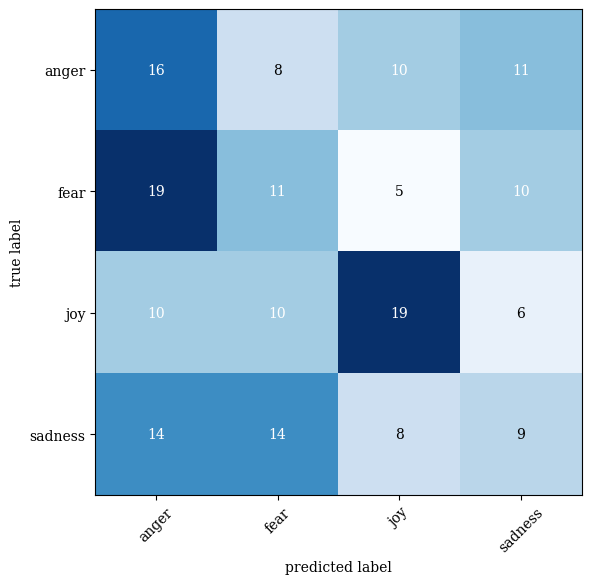

In [64]:
plt.rc('font', family = 'Serif')

mat = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=mat, figsize=(6,6), class_names = class_names, show_normed=False)
plt.tight_layout()
fig.savefig('cm.png')
fig

In [65]:
sklearn.metrics.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

SyntaxError: invalid syntax (<ipython-input-65-c73d89358832>, line 1)